In [5]:
import sys
import os

# Adjust the path based on your directory structure
module_path = os.path.abspath(os.path.join('..', '..'))  # Moves two directories up
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Now you can import c2qa and other modules from bosonic-qiskit
import c2qa
import qiskit
import numpy as np
# Math, numerics, and graphing
import numpy as np
import scipy as sp
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.special import factorial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
from scipy.integrate import trapz
from scipy.special import eval_hermite
from scipy.optimize import minimize_scalar
%matplotlib inline

# Introduction to GKP Codes
A short introduction to GKP codes, essentially detailing the functions that can be found in `GKP_functions.py`. 

### GKP Fock States

First, a useful function will be `fock_to_position` which takes in a Fock state and returns the corresponding position wavefunction, and we can use this to define `fock_coefficients_to_position` which can take as input a superposition of Fock states (determined by their coefficients) and return the corresponding wavefunction.


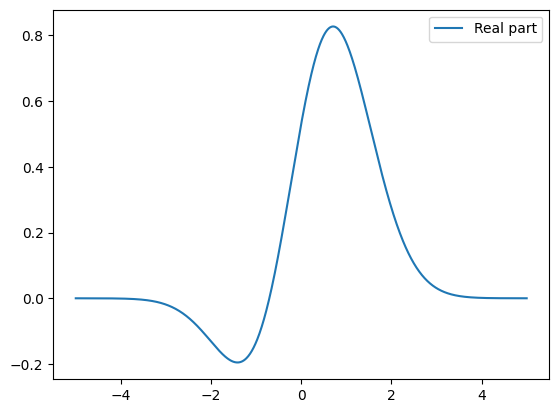

In [6]:
def fock_to_position(n, q):
    '''Returns the Fock position wavefunctions defined over q space.

    Args:
        n (int): Fock index
        q (array): position values

    Returns:
        position_wf_fock (array): nth Fock state wavefunction
    '''

    position_wf_fock = ((1/np.sqrt((2**n)*factorial(n)))*(np.pi**-0.25)
            *np.exp(-(q**2)/2)*eval_hermite(n,q) ) #Employs the scipy.special eval_hermite function

    return position_wf_fock

def fock_coefficients_to_position(coeffs, q):
    '''Returns the position wavefunction for a superposition of Fock states
    defined by the given Fock coefficients.

    Args:
        coeffs (array): array of Fock coefficients
        q (array): position values over which to compute the wavefunction

    Returns:
        wavefunction (array): resulting wavefunction in the position basis
    '''
    wavefunction = np.zeros_like(q, dtype=complex)  # Initialize the wavefunction

    # Loop over all Fock coefficients and sum the weighted Fock states
    for n, coeff in enumerate(coeffs):
        fock_wf = fock_to_position(n, q)  # Get the nth Fock state in position basis
        wavefunction += coeff * fock_wf   # Add the weighted Fock state to the total wavefunction

    return wavefunction

# Example Fock coefficients (some arbitrary values)
coeffs = np.array([1/np.sqrt(2), 1/np.sqrt(2)])

# Position grid
q = np.linspace(-5, 5, 1000)

# Get the resulting wavefunction
wavefunction = fock_coefficients_to_position(coeffs, q)

# Plot the real parts of the wavefunction
plt.plot(q, wavefunction.real, label='Real part')
plt.legend()
plt.show()

We define our GKP state, built on from [here](https://github.com/XanaduAI/approximate-GKP-prep/blob/master/Formalism.ipynb). This allows us to get both the position wavefunction, and Fock coefficients of any rectangular GKP qubit. We define the normalised GKP state using a Guassian envelope, e.g. $|\psi_{\triangle}\rangle = e^{-\triangle \hat{n}}|\psi\rangle$, where $\hat{n}$ is the number operator, $\triangle$ is the squeezing parameter in **dB** and $|\psi\rangle$ is the ideal GKP state.

Now let's use bosonic qiskit to initialize a qumode a plot the wigner funciton of the GKP state.

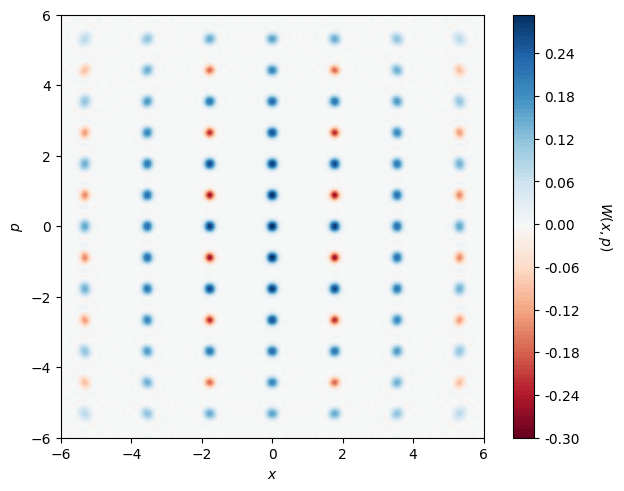

In [7]:
def gkp_fock_coeff(n, combs=100, alpha=np.sqrt(np.pi), mu=0, aspect_ratio=1):
    '''Returns the nth Fock coefficient for the ideal logical GKP state.

    Args:
        n (int): index of Fock state
        combs (int): number of delta spikes in the ideal state used to 
                        calculate inner product with Fock state
        alpha (float): GKP lattice constant
        mu (0 or 1): logical value of GKP state
        aspect_ratio (float): the aspect ratio lambda that scales position and momentum lattice spacing

    Returns:
        coeff (complex): inner product between ideal GKP and nth 
            Fock states.
    '''
    # adjust alpha by aspect_ratio in the q direction
    alpha_q = alpha * aspect_ratio
    # q values from which to sample the nth Fock state
    samples = (mu + np.arange(-combs/2, 1+combs/2)*2)*alpha_q
    # sum of sampled values to yield inner product
    coeff = np.sum(fock_to_position(n, samples))
    return coeff

def gkp_fock(qubit, eps, q, n_max=100, norm=True, aspect_ratio=1): 
    '''Returns the epsilon GKP q wavefunction and coefficients in the 
        Fock basis.

    Args:
        qubit (array): qubit state in logical basis
        eps (float): value of epsilon
        q (array): array of q values for q wavefunction
        n_max (int): Fock cutoff
        norm (Boolean): whether to return a normalized state
        aspect_ratio (float): the aspect ratio lambda that scales position and momentum lattice spacing

    Returns:
        gkp (array): q wavefunction
        coeffs (array): Fock coefficients up to cutoff.
    '''
    qubit = qubit/np.linalg.norm(qubit)
    gkp = 0
    coeffs = np.zeros(n_max+1, dtype=complex)
    # initialize normalization constant
    N = 0
    for i in range(n_max+1):
        # calculate nth coefficient and weight it with an epsilon dependent exponential
        coeff = (qubit[0]*gkp_fock_coeff(i, mu=0, aspect_ratio=aspect_ratio) + qubit[1]*gkp_fock_coeff(i, mu=1, aspect_ratio=aspect_ratio))*np.exp(-i*eps)
        coeffs[i] = coeff
        gkp += coeff*fock_to_position(i, q)
        if norm:
            N += np.absolute(coeff)**2
    if norm:
        gkp = gkp/np.sqrt(N)
        coeffs = coeffs/np.sqrt(N)
    return gkp, coeffs

# Define the qubit and q values
qubit = np.array([1, 0])
q = np.linspace(-10, 10, 1000)
eps = 0.019
# Generate the GKP state and coefficients
gkp, gkp_coeffs = gkp_fock(qubit, eps, q)


#Initialize circuit
qmr = c2qa.QumodeRegister(
    num_qumodes=1,
    num_qubits_per_qumode=7) #qumode
qbr = qiskit.QuantumRegister(1) #qubit
cr = qiskit.ClassicalRegister(1) #readout bit
sBs_circuit = c2qa.CVCircuit(qmr, qbr, cr) #create circuit

sBs_circuit.cv_initialize(list(gkp_coeffs), qmr[0]) #initialize gkp |0> state

state,_,_ = c2qa.wigner.simulate(sBs_circuit)
plot = c2qa.wigner.plot_wigner(sBs_circuit, state)

### Qunaught state
The square qunaught state is defined as:
$$
|0\rangle_{\text{qunaught}} \propto \sum_{n \in Z} |\hat{q} = n\sqrt{2 \pi}\rangle \propto \sum_{n \in Z} |\hat{p} = n\sqrt{2 \pi}\rangle
$$
The qunaught doesn't carry any logical information.

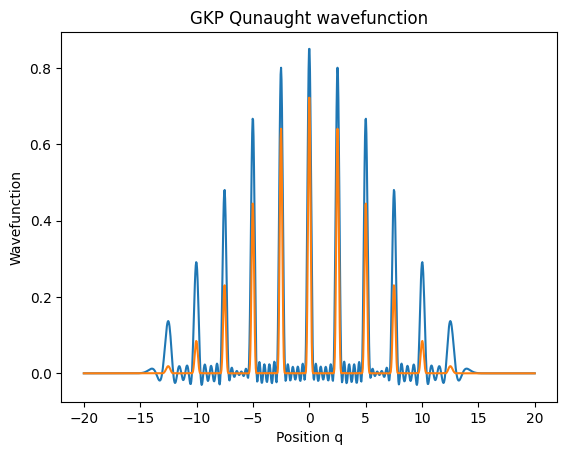

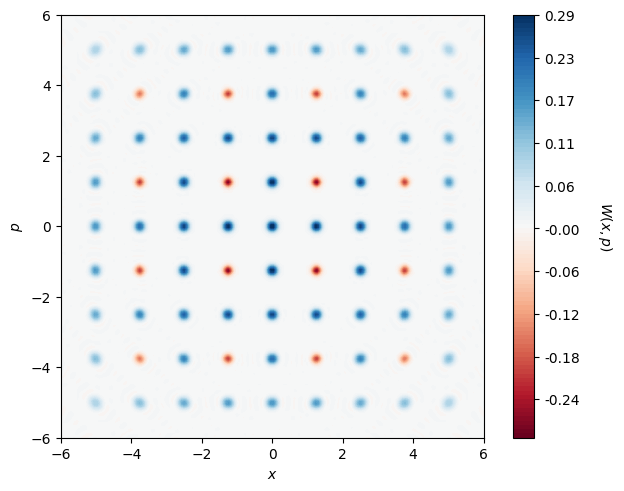

In [8]:
def qunaught_fock_coeff(n, combs=100, alpha=np.sqrt(2*np.pi), aspect_ratio=1):
    '''Returns the nth Fock coefficient for the ideal qunaught GKP state.

    Args:
        n (int): index of Fock state
        combs (int): number of delta spikes in the ideal state used to 
                        calculate inner product with Fock state
        alpha (float): Qunaught lattice constant (default is sqrt(2*pi))
        aspect_ratio (float): the aspect ratio lambda that scales position and momentum lattice spacing

    Returns:
        coeff (complex): inner product between ideal qunaught GKP and nth 
            Fock states.
    '''
    # adjust alpha by aspect_ratio in the q direction
    alpha_q = alpha * aspect_ratio
    # q values from which to sample the nth Fock state
    samples = (np.arange(-combs/2, 1+combs/2))*alpha_q
    # sum of sampled values to yield inner product
    coeff = np.sum(fock_to_position(n, samples))
    return coeff


def qunaught_fock(eps, q, n_max=100, norm=True, aspect_ratio=1): 
    '''Returns the epsilon-qunaught q wavefunction and coefficients in the 
        Fock basis.

    Args:
        eps (float): squeezing parameter (epsilon) for the qunaught state
        q (array): array of q values for q wavefunction
        n_max (int): Fock cutoff (maximum number of Fock states considered)
        norm (Boolean): whether to return a normalized state
        aspect_ratio (float): the aspect ratio lambda that scales position and momentum lattice spacing

    Returns:
        qunaught (array): q wavefunction for qunaught state
        coeffs (array): Fock coefficients up to cutoff.
    '''
    alpha = np.sqrt(2*np.pi)  # Lattice constant for qunaught is sqrt(2*pi)

    qunaught = 0
    coeffs = np.zeros(n_max+1, dtype=complex)
    # initialize normalization constant
    N = 0
    for i in range(n_max+1):
        # calculate nth coefficient for the qunaught state, with aspect_ratio
        coeff = qunaught_fock_coeff(i, alpha=alpha, aspect_ratio=aspect_ratio) * np.exp(-i * eps)
        coeffs[i] = coeff
        qunaught += coeff * fock_to_position(i, q)
        if norm:
            N += np.absolute(coeff)**2
    
    # Check if normalization constant is non-zero before dividing
    if norm and N > 0:
        qunaught = qunaught / np.sqrt(N)
        coeffs = coeffs / np.sqrt(N)
    elif N == 0:
        print("Warning: Normalization constant is zero, skipping normalization.")
        
    return qunaught, coeffs


# Define the q value
q = np.linspace(-20, 20, 1000)
eps =  0.019

# Generate the GKP state and coefficients
qunaught, qunaught_coeffs = qunaught_fock(eps, q, norm = True)

#plot the qunaught wavefunction
plt.plot(q, qunaught)
plt.plot(q, np.abs(qunaught)**2)
plt.title(f'GKP Qunaught wavefunction')
plt.xlabel('Position q')
plt.ylabel('Wavefunction')
plt.show()


# #Initialize circuit
qmr = c2qa.QumodeRegister(
    num_qumodes=1,
    num_qubits_per_qumode=7) #qumode
qbr = qiskit.QuantumRegister(1) #qubit
cr = qiskit.ClassicalRegister(1) #readout bit
qunaught_circuit = c2qa.CVCircuit(qmr, qbr, cr) #create circuit

qunaught_circuit.cv_initialize(list(qunaught_coeffs), qmr[0]) #initialize gkp |0> state
qunaught_circuit.h(qbr[0]) # Intialize qubit in |+>


state,_,_ = c2qa.wigner.simulate(qunaught_circuit)
plot = c2qa.wigner.plot_wigner(qunaught_circuit, state)

# General GKP States
Recall the stabilizers of the GKP code are defined as:
$$
S_q = X(2\sqrt{\pi}) = e^{-i 2\sqrt{\pi} \hat{q}}
$$
$$
S_p = Z(2\sqrt{\pi}) = e^{i 2\sqrt{\pi} \hat{p}}
$$
To ensure that the stabilizers commute, we require:
$$
[X(g), Z(h)] = 0 \implies gh = 2\pi d
$$
where $ d $ is the code dimension. For $ d = 2 $, we can define a rectangular lattice with aspect ratio $ r $ by setting:
$$
g = 2 r \sqrt{\pi}, h = \frac{2 \sqrt{\pi}}{r}
$$

This parameterization allows us to explore different lattice shapes while maintaining the commutation relations necessary for error correction.
